Build a canonical correlation analysis (CCA) model to cast fasttext and moti into the same latent space. 

* Self-search rank is improved against simple fasttext lookups using transformed descr-keywords and descr-moti
* These improvements do not, however, move the majority of self-search queries below rank 50
* CCA changes the fasttext space, causing relative distances to change and hampering overall embedding quality metrics

## Imports, etc.

In [1]:
## Magic numbers
FASTTEXT_WIDTH = 300
MOTI_WIDTH = 128
NUM_CONTENT_PER_INSIGHT = 40
NUM_KEYWORDS_PER_CONTENT = 50

In [2]:
FILES = {
    # wiki-news-300d-1M.vec.zip: 1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens).
    'wiki.en.bin':                             '/home/pmccarthy/projects/audiencefinder/data/wiki.en.bin', 
    'cca_model_10.joblib':                     '/home/pmccarthy/projects/audiencefinder/MLE-4611/cca_model_10.joblib',
    'cca_model_20.joblib':                     '/home/pmccarthy/projects/audiencefinder/MLE-4611/cca_model_20.joblib',
    'cca_model_30.joblib':                     '/home/pmccarthy/projects/audiencefinder/MLE-4611/cca_model_30.joblib',
    'interests.tsv':                           '/home/pmccarthy/projects/audiencefinder/interests.tsv',
    'keywords.tsv':                            '/home/pmccarthy/projects/audiencefinder/keywords.tsv',
    'mle4600_adv_contextual_keywords.parquet': '/home/pmccarthy/projects/audiencefinder/mle4600_adv_contextual_keywords.parquet',
    'embeddings_20210426_153704.npy':          '/home/pmccarthy/projects/audiencefinder/data/embeddings_20210426_153704.npy',
    'gensim_fasttext.bin':                     '/home/pmccarthy/projects/audiencefinder/data/gensim_fasttext.bin'
}

In [3]:
import collections 
import fasttext
import io
import joblib
import json
import mmh3
import numpy as np
import os
import pandas as pd
from plotnine import *
from scipy import stats
import sys

import gensim
from gensim.test.utils import datapath
from gensim.models import KeyedVectors

from scipy.stats import rankdata

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cross_decomposition import CCA
from sklearn.metrics.pairwise import cosine_similarity

from typing import Dict, List

## Helper Functions

In [4]:
class JsonReader(BaseEstimator, TransformerMixin):
    
    def __init__(self, stemming=False):
        self.stemming = stemming
        
        super(JsonReader).__init__()
    
    
    @staticmethod
    def _stem_and_add(json_str):
        """
        Transform each token into its stemmed substring,
        and build the dict as {stem: (sum of counts of words with this stem)}
        """
        stemmed_counts = collections.defaultdict(int)        
        stem = nltk.stem.SnowballStemmer('english')
        
        json_dict = json.loads(json_str)
        
        for k in json_dict.keys():
            stemmed_counts[stem.stem(k)] += json_dict[k]
        
        return stemmed_counts
    
    
    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X):        
        if self.stemming:
            return X.apply(self._stem_and_add)
        else:
            return X.apply(json.loads)

In [5]:
class TransformAndFasttext():
    
    def __init__(self, ft_model, sk_model):
        
        self.sk_model = sk_model
        self.ft_model = ft_model
    
    def get_sentence_vector(self, X):
        
        return self.sk_model.transform(np.expand_dims(
            self.ft_model.get_sentence_vector(X)
            ,0))
    
    def get_content_vector(self, Y):
    
        dummy_vals = np.zeros((Y.shape[0], self.sk_model.x_rotations_.shape[0]))

        _, y_transformed = self.sk_model.transform(dummy_vals, Y)

        return np.mean(y_transformed, axis=0, keepdims=True)
        

In [6]:
class ColumnComparison():
    
    def __init__(self, basis_text: pd.Series, compare_text: pd.Series, model: fasttext.FastText):
        
        assert basis_text.shape[0] == compare_text.shape[0], "basis text and compare text Series must have same length"
        
        self.basis_text = basis_text
        self.compare_text = compare_text
        self.basis_vectors = basis_text.apply(model.get_sentence_vector)
        self.compare_vectors = compare_text.apply(model.get_sentence_vector)
        
    @property
    def distance(self) -> pd.Series:
        
        distance_arr = 1.0 - cosine_similarity(
            np.vstack(self.basis_vectors),
            np.vstack(self.compare_vectors)
        )
                
        assert np.array_equal(distance_arr.shape, 
                              np.array([self.basis_text.shape[0], self.compare_text.shape[0]]))
        
        return distance_arr
    
    @property
    def self_distance(self) -> np.ndarray:
        """
        """
        
        return np.diag(self.distance)
    
    @property
    def best_basis_compare_distance(self) -> np.ndarray:
        """
        Basis is X, Compare is Y, so for the Xth row
        find the smallest element of Y
        """
        
        # min along axis 1
        return np.min(self.distance, axis=1)
    
    @property
    def best_compare_for_basis(self) -> pd.Series:
        """
        Target is X, Compare is Y, so for the Xth row
        find which element of Y is the smallest
        """
        
        # min along axis 1
        min_indices = np.argmin(self.distance, axis=1)
        return self.compare_text.values[tuple([min_indices])]
        
    @property
    def basis_of_best_compare(self) -> pd.Series:
        """
        For an entry of self.basis_text, first find the 
        self.compare_text that is nearest by cosine distance 
        and get the basis corresponding to that match.
        """
        
        min_indices = np.argmin(self.distance, axis=0)
        return self.basis_text.values[tuple([min_indices])]
    
    @property
    def basis_self_rank(self) -> np.ndarray:
        """
        For a given value in self.compare_text, rank
        self.basis_text in terms of closeness by cosine distance.
        Return the rank of the basis corresponding to the compare_text.
        """
        
        # rank down the column, i.e. rank basis in terms of each compare
        return np.diag(rankdata(self.distance, axis=0))

In [104]:
class MOTIColumnComparison(ColumnComparison):
    """
    consider compare text to be a list of moti vectors instead of a list of keywords
    """
    
    def __init__(self, basis_text: pd.Series, compare_text: pd.Series, model):
        
        self.basis_text = basis_text
        self.compare_text = compare_text
        
        self.basis_vectors = basis_text.apply(model.get_sentence_vector)
        self.compare_vectors = compare_text.apply(model.get_content_vector)
        

## Play with CCA

### scikit-example: [link](https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.CCA.html?highlight=cca#sklearn.cross_decomposition.CCA)

In [8]:
X = [[0., 0., 1.], [1.,0.,0.], [2.,2.,2.], [3.,5.,4.]]
Y = [[0.1, -0.2], [0.9, 1.1], [6.2, 5.9], [11.9, 12.3]]

sk_cca = CCA(n_components=1)
sk_cca.fit(X, Y)
X_c, Y_c = sk_cca.transform(X, Y)

In [9]:
# Transform without Y
np.array_equal(
    sk_cca.transform(X),
    X_c)

True

### PSU Example [link](https://online.stat.psu.edu/stat505/lesson/13)

In [10]:
dat = """
  93.0  96.0  97.8  9  12  9  20
  88.8  91.8  96.8  7  10  10  15
  95.0  100.3  99.0  8  12  9  26
  101.3  103.8  106.8  13  14  12  29
  102.0  107.8  103.0  10  15  12  32
  95.8  97.5  99.3  10  14  11  21
  95.5  99.5  99.0  9  12  9  25
  110.8  122.0  115.3  18  20  15  51
  102.8  108.3  103.8  10  17  13  31
  106.8  120.5  102.0  14  18  11  39
  103.3  109.8  104.0  12  17  12  32
  99.5  111.8  100.3  10  18  8  31
  103.5  112.5  107.0  16  17  11  34
  99.5  105.5  102.3  8  10  11  34
  100.0  107.0  102.8  13  10  8  34
  81.5  93.5  95.0  7  9  5  16
  101.3  105.3  102.8  11  12  11  32
  103.3  110.8  103.5  11  14  11  35
  95.3  104.3  103.0  5  14  13  30
  99.5  105.3  106.3  17  17  11  27
  88.5  95.3  95.8  10  12  7  15
  99.3  115.0  104.3  5  11  11  42
  87.5  92.5  95.8  9  9  7  16
  105.3  114.0  105.3  12  15  12  37
  107.0  121.0  109.0  16  19  12  39
  93.3  102.0  97.8  10  15  7  23
  106.8  118.0  107.3  14  16  12  39
  106.8  120.0  104.8  10  16  11  49
  92.3  90.8  99.8  8  10  13  17
  106.3  121.0  104.5  9  17  11  44
  106.0  119.5  110.5  18  15  10  43
  88.3  92.8  96.8  13  11  8  10
  96.0  103.3  100.5  7  15  11  27
  94.3  94.5  99.0  10  12  11  19
  106.5  121.5  110.5  18  17  10  42
  106.5  115.5  107.0  8  13  14  47
  92.0  99.5  103.5  18  16  8  18
  102.0  99.8  103.3  13  12  14  28
  108.3  122.3  108.5  15  19  12  41
  106.8  119.0  106.8  14  20  12  37
  102.5  109.3  103.8  9  17  13  32
  92.5  102.5  99.3  13  15  6  23
  102.8  113.8  106.8  17  20  10  32
  83.3  87.3  96.3  1  5  9  15
  94.8  101.8  99.8  7  16  11  24
  103.5  112.0  110.8  18  13  12  37
  89.5  96.0  97.3  7  15  11  14
  84.3  89.8  94.3  8  8  8  9
  104.3  109.5  106.5  14  12  12  36
  106.0  118.5  105.0  12  16  11  39
"""

### Schools Example [link](https://towardsdatascience.com/understanding-how-schools-work-with-canonical-correlation-analysis-4c9a88c6b913)

In [11]:
df = pd.read_csv("cca/2016 School Explorer.csv")

In [12]:
# choose relevant features
df = df[['Rigorous Instruction %',
      'Collaborative Teachers %',
     'Supportive Environment %',
       'Effective School Leadership %',
   'Strong Family-Community Ties %',
    'Trust %','Average ELA Proficiency',
       'Average Math Proficiency']]
# drop missing values
df = df.dropna()
# separate X and Y groups
X = df[['Rigorous Instruction %',
      'Collaborative Teachers %',
     'Supportive Environment %',
       'Effective School Leadership %',
   'Strong Family-Community Ties %',
    'Trust %'
      ]]
Y = df[['Average ELA Proficiency',
       'Average Math Proficiency']]

In [13]:
for col in X.columns:
    X[col] = X[col].str.strip('%')
    X[col] = X[col].astype('int')
# Standardise the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=True, with_std=True)
X_sc = sc.fit_transform(X)
Y_sc = sc.fit_transform(Y)

/home/pmccarthy/opt/miniconda3/envs/mle4587/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/pmccarthy/opt/miniconda3/envs/mle4587/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Penguins example

In [14]:
# https://cmdlinetips.com/2020/12/canonical-correlation-analysis-in-python/

link2data = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv"
pengdf = pd.read_csv(link2data)
pengdf = pengdf.dropna()
pengdf.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE


In [15]:
X = pengdf[['bill_length_mm','bill_depth_mm']]
X.head()

,bill_length_mm,bill_depth_mm
0,39.1,18.7
1,39.5,17.4
2,40.3,18.0
4,36.7,19.3
5,39.3,20.6


In [16]:
X_mc = (X-X.mean())/(X.std())
X_mc.head()

,bill_length_mm,bill_depth_mm
0,-0.894695,0.779559
1,-0.821552,0.119404
2,-0.675264,0.424091
4,-1.333559,1.084246
5,-0.858123,1.744400


In [17]:
Y = pengdf[['flipper_length_mm','body_mass_g']]
Y.head()

,flipper_length_mm,body_mass_g
0,181.0,3750.0
1,186.0,3800.0
2,195.0,3250.0
4,193.0,3450.0
5,190.0,3650.0


In [18]:
Y_mc = (Y-Y.mean())/(Y.std())
Y_mc.head()

,flipper_length_mm,body_mass_g
0,-1.424608,-0.567621
1,-1.067867,-0.505525
2,-0.425733,-1.188572
4,-0.568429,-0.940192
5,-0.782474,-0.691811


In [19]:
peng_cca = CCA(n_components=2)
peng_cca.fit(X_mc, Y_mc)
X_c, Y_c = peng_cca.transform(X_mc, Y_mc)

In [20]:
print(X_c.shape)
print(Y_c.shape)


(333, 2)
(333, 2)


In [21]:
cc_res = pd.DataFrame({"CCX_1":X_c[:, 0],
                       "CCY_1":Y_c[:, 0],
                       "CCX_2":X_c[:, 1],
                       "CCY_2":Y_c[:, 1],
                       "Species":pengdf.species.tolist(),
                       "Island":pengdf.island.tolist(),
                       "sex":pengdf.sex.tolist()})

In [22]:
cc_res.head()

,CCX_1,CCY_1,CCX_2,CCY_2,Species,Island,sex
0,-1.186252,-1.408795,-0.010367,0.682866,Adelie,Torgersen,MALE
1,-0.709573,-1.053857,-0.456036,0.429879,Adelie,Torgersen,FEMALE
2,-0.790732,-0.393550,-0.130809,-0.839620,Adelie,Torgersen,FEMALE
3,-1.718663,-0.542888,-0.073623,-0.458571,Adelie,Torgersen,FEMALE
4,-1.772295,-0.763548,0.736248,-0.014204,Adelie,Torgersen,MALE


In [23]:
pengdf.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE


In [24]:
np.corrcoef(X_c[:, 0], Y_c[:, 0])
# array([[1.        , 0.78763151],
#        [0.78763151, 1.        ]])

array([[1.        , 0.78763151],
       [0.78763151, 1.        ]])

In [25]:
np.corrcoef(X_c[:, 1], Y_c[:, 1])

array([[1.        , 0.08638695],
       [0.08638695, 1.        ]])

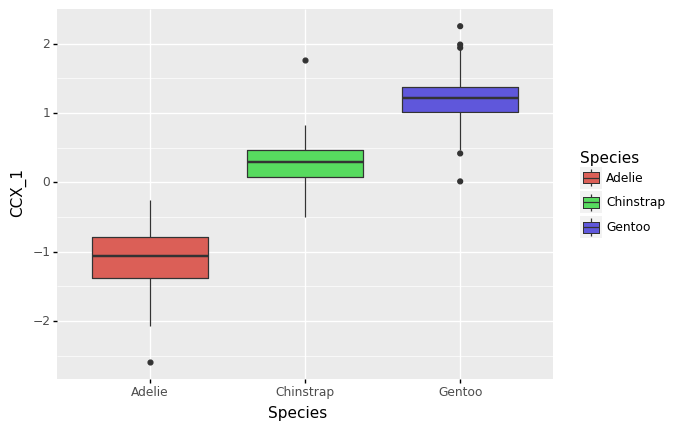

<ggplot: (8750040063445)>

In [26]:
ggplot(cc_res, aes(x='Species',y='CCX_1',fill='Species')) + geom_boxplot()

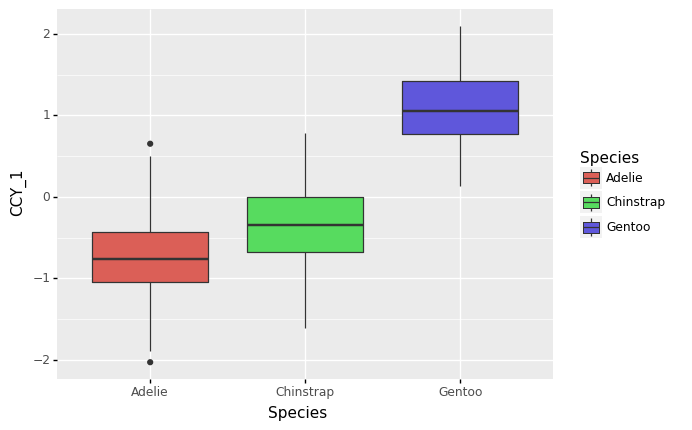

<ggplot: (8750040179465)>

In [27]:
ggplot(cc_res, aes(x='Species',y='CCY_1',fill='Species')) + geom_boxplot()

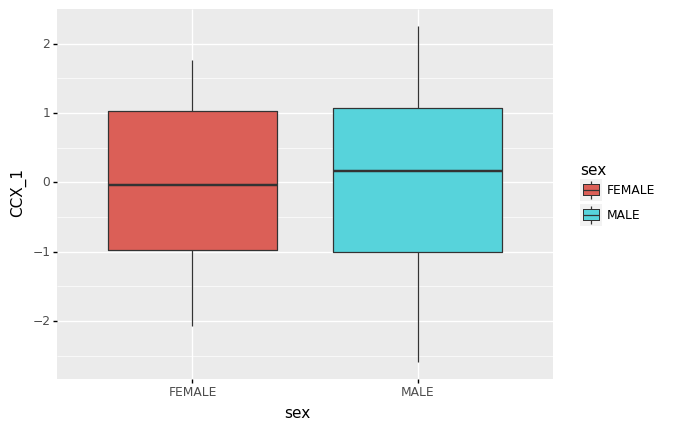

<ggplot: (8750040107733)>

In [28]:
ggplot(cc_res, aes(x='sex',y='CCX_1', fill='sex')) + geom_boxplot()

In [29]:
cc_res

,CCX_1,CCY_1,CCX_2,CCY_2,Species,Island,sex
0,-1.186252,-1.408795,-0.010367,0.682866,Adelie,Torgersen,MALE
1,-0.709573,-1.053857,-0.456036,0.429879,Adelie,Torgersen,FEMALE
2,-0.790732,-0.393550,-0.130809,-0.839620,Adelie,Torgersen,FEMALE
3,-1.718663,-0.542888,-0.073623,-0.458571,Adelie,Torgersen,FEMALE
4,-1.772295,-0.763548,0.736248,-0.014204,Adelie,Torgersen,MALE
...,...,...,...,...,...,...,...
328,1.572414,0.905520,-0.927902,0.088041,Gentoo,Biscoe,FEMALE
329,1.322035,0.979352,-0.748356,-0.070682,Gentoo,Biscoe,FEMALE
330,1.377092,1.448490,0.220933,0.630948,Gentoo,Biscoe,MALE
331,0.934766,0.753673,-0.752510,0.564495,Gentoo,Biscoe,FEMALE


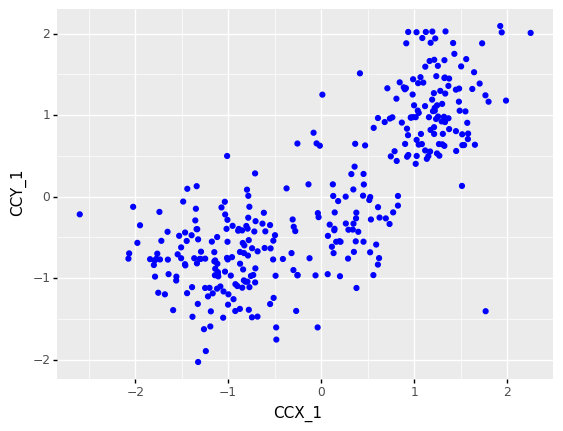

<ggplot: (8750035837465)>

In [30]:
ggplot(cc_res, aes(x='CCX_1',y='CCY_1')) + geom_point(color='blue')

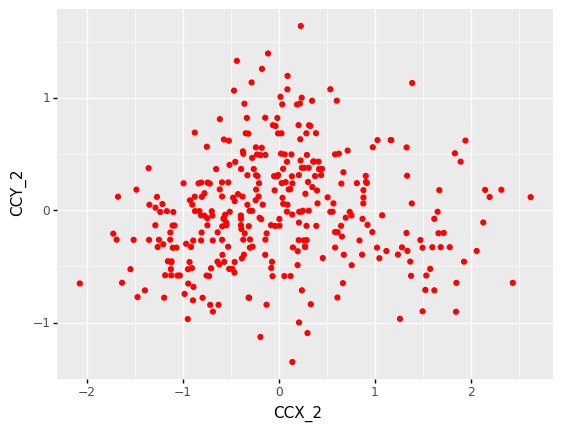

<ggplot: (8750035812997)>

In [31]:
ggplot(cc_res, aes(x='CCX_2',y='CCY_2')) + geom_point(color='red')

## Load keywords

### Keywords API

In [32]:
interests_df = pd.read_table(FILES['interests.tsv'],
                             names=['interest_id','interest_type_id','descr'])

interests_df.head(n=3)

,interest_id,interest_type_id,descr
0,36864,110,Vegetarians
1,77825,110,Small Business Administration Cares Act Resear...
2,1,110,Fitness Enthusiasts


In [33]:
keywords_from_api_df = pd.read_table(FILES['keywords.tsv'],
                             names=['interest_id','keyword','n'])

keywords_from_api_df.head(n=3)

,interest_id,keyword,n
0,36864,desserts,13
1,36864,gluten,5
2,36864,quick,5


In [34]:
keyword_api_df = pd.merge(
    interests_df,
    keywords_from_api_df, on='interest_id', how='left')

keyword_api_df.head()

,interest_id,interest_type_id,descr,keyword,n
0,36864,110,Vegetarians,desserts,13
1,36864,110,Vegetarians,gluten,5
2,36864,110,Vegetarians,quick,5
3,36864,110,Vegetarians,foods,14
4,36864,110,Vegetarians,wholesome,5


In [35]:
keyword_api_dict = collections.defaultdict(dict)

for i, r in keyword_api_df.iterrows():
    keyword_api_dict[r['descr']][r['keyword']] = r['n']

In [36]:
keyword_api_json_df = (
    pd.merge(
        
        pd.DataFrame([(k, json.dumps(keyword_api_dict[k])) for k in keyword_api_dict.keys()])
        .rename(columns={0:'descr',1:'keywords_json'}),
        
        keyword_api_df[['interest_id','descr']].drop_duplicates(),
        
        on='descr',
        how='left')
)

keyword_api_json_df.head(n=3)

,descr,keywords_json,interest_id
0,Vegetarians,"{""desserts"": 13, ""gluten"": 5, ""quick"": 5, ""foo...",36864
1,Small Business Administration Cares Act Resear...,"{""capital"": 7, ""education"": 4, ""lawyers"": 4, ""...",77825
2,Fitness Enthusiasts,"{""celebrity"": 3, ""foods"": 5, ""beauty"": 5, ""str...",1


### Advanced Contextual

In [37]:
adv_cont_keywords_df = (
    pd.read_parquet(FILES['mle4600_adv_contextual_keywords.parquet'])
        .assign(keyword_list = lambda x: x['keywords_json'].apply(lambda y: list(json.loads(y).keys())))    
)

print(adv_cont_keywords_df.shape)

# ensure each row is a unique interest
assert adv_cont_keywords_df['interest_id'].nunique() == adv_cont_keywords_df.shape[0]

adv_cont_keywords_df.head(n=3)

(4525, 10)


,interest_type_id,interest_id,entity_id,descr,summary,domains,content_id,n_url,keywords_json,keyword_list
0,110,17744,46444,Vegans Q1 2018 (Oatly),Vegans Q1 2018 (Oatly),"[blissfulbasil.com, rabbitandwolves.com, emili...","[1hv6i, 1lyy4, 1mj5v, 1mp53, 1qxr8, 1jc3a, 1ih...",3297,"{""vegan"": 344, ""sauce"": 306, ""recipe"": 254, ""t...","[vegan, sauce, recipe, tofu, soup, salad, rice..."
1,110,56010,627953,Wedding Content Researchers DNU,Wedding Content Researchers DNU,"[mywedding.com, travelfashiongirl.com, wedding...","[mjkp, 1l0k1, 1ncn8, 1dbyf, fhmi, 2xg, qwd1, 1...",21466,"{""wedding"": 3418, ""dress"": 702, ""venue"": 692, ...","[wedding, dress, venue, guests, wedding day, c..."
2,112,11655,40981,Assorted Topics (This Audience Are Interested ...,People in this audience are interested in abbr...,"[usingenglish.com, militaryfactory.com, online...","[d7x, my3s, u5u2, 1o3d4, kre2, 15d3i, unb1, u7...",1426,"{""cell"": 87, ""formula"": 72, ""cell range"": 48, ...","[cell, formula, cell range, array formula, exc..."


### Common Audiences

In [38]:
common_audiences_list = list(
    set(keyword_api_json_df['interest_id'].tolist())
        .intersection(set(adv_cont_keywords_df['interest_id'].tolist()))
)

len(common_audiences_list)

1991

In [39]:
common_audiences = list(
    set(keyword_api_json_df['descr'].tolist())
        .intersection(set(adv_cont_keywords_df['descr'].tolist()))
)[0:10]

common_audiences

['Local & Travel England - East Midlands',
 'Bird Watching',
 'DIY Upcycle Home Project Planners',
 'Russia Cluster',
 'Parents of High School Students',
 'Film Production',
 'Credit Card Researchers',
 'Peru Media',
 'Canada Job Seekers Cluster',
 'Writing Resources']

In [40]:
adv_cont_keywords_df.head()

,interest_type_id,interest_id,entity_id,descr,summary,domains,content_id,n_url,keywords_json,keyword_list
0,110,17744,46444,Vegans Q1 2018 (Oatly),Vegans Q1 2018 (Oatly),"[blissfulbasil.com, rabbitandwolves.com, emili...","[1hv6i, 1lyy4, 1mj5v, 1mp53, 1qxr8, 1jc3a, 1ih...",3297,"{""vegan"": 344, ""sauce"": 306, ""recipe"": 254, ""t...","[vegan, sauce, recipe, tofu, soup, salad, rice..."
1,110,56010,627953,Wedding Content Researchers DNU,Wedding Content Researchers DNU,"[mywedding.com, travelfashiongirl.com, wedding...","[mjkp, 1l0k1, 1ncn8, 1dbyf, fhmi, 2xg, qwd1, 1...",21466,"{""wedding"": 3418, ""dress"": 702, ""venue"": 692, ...","[wedding, dress, venue, guests, wedding day, c..."
2,112,11655,40981,Assorted Topics (This Audience Are Interested ...,People in this audience are interested in abbr...,"[usingenglish.com, militaryfactory.com, online...","[d7x, my3s, u5u2, 1o3d4, kre2, 15d3i, unb1, u7...",1426,"{""cell"": 87, ""formula"": 72, ""cell range"": 48, ...","[cell, formula, cell range, array formula, exc..."
3,110,94779,653665,Resort Vacationers,Resort Vacationers,"[travelpulse.com, aviewfrommyseat.com, allhiph...","[mjkp, 12g0d, 1p4o4, 1nayh, 1k3bc, 1o59r, f9h5...",1047,"{""wedding"": 153, ""venue"": 88, ""guests"": 38, ""c...","[wedding, venue, guests, cruise, caribbean, pa..."
4,112,11401,40727,Vermont Cluster,People in this audience are interested in a va...,"[sevendaysvt.com, dailygazette.com, wwnytv.com...","[w68c, ssg4, epcs, fz2d, 10d5y, 1ggqg, cj9e, 1...",4642,"{""new hampshire"": 351, ""covid-19"": 345, ""polic...","[new hampshire, covid-19, police, haverhill, t..."


## Test CCA build

In [41]:
## See what dimensions the system can handle

num_content = adv_cont_keywords_df.explode('content_id')['content_id'].nunique()

num_content

15744

In [42]:
keyword_api_words = keyword_api_json_df['keywords_json'].apply(lambda x: list(json.loads(x).keys())).explode().unique()

num_keyword_api_words = keyword_api_json_df['keywords_json'].apply(lambda x: list(json.loads(x).keys())).explode().nunique()

num_keyword_api_words

4700

In [43]:
adv_cont_words = adv_cont_keywords_df['keywords_json'].apply(lambda x: list(json.loads(x).keys())).explode().unique()

num_adv_cont_words = adv_cont_keywords_df['keywords_json'].apply(lambda x: list(json.loads(x).keys())).explode().nunique()

num_adv_cont_words

120833

In [44]:
total_words = len(list(set(adv_cont_words).union(set(keyword_api_words))))
total_words

random_kw_moti_pairings = np.random.rand(655609, MOTI_WIDTH+FASTTEXT_WIDTH) # see if it blows up

In [ ]:
my_cca = CCA(n_components=3)

my_cca.fit(random_kw_moti_pairings[:,128:], random_kw_moti_pairings[:,:128])

random_kw_moti_pairings.shape

## Build CCA

### Get keyword - site correspondences

In [45]:
JOBNAME = 'MLE-4661 - Try CCA'

dist_archives = 'hdfs:///user/pmccarthy/conda/webtools37.zip#webtools37'

# os.environ['SPARK_HOME'] = '/home/pmccarthy/nas/opt/spark-2.4.7-bin-hadoop2.7'
os.environ['SPARK_HOME'] = '/opt/spark-hadrs2'
os.environ['PYSPARK_PYTHON'] = './webtools37/webtools37/bin/python'

sys.path.insert(0,os.path.join(os.environ['SPARK_HOME'],'python','lib','py4j-src.zip'))
sys.path.append(os.path.join(os.environ['SPARK_HOME'],'python'))

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import window as W


# spark = (SparkSession
#          .builder
#          .enableHiveSupport()
#          .appName(f"{os.uname()[1].split('.')[0]}: {JOBNAME}")
#          .config('spark.master','yarn')
#          .config('spark.yarn.deployMode','client')
#          .config('spark.executor.cores',1)
#          .config('spark.executor.memory','2g')
#          .config('spark.driver.memory','5g')
#          .config('spark.dynamicAllocation.maxExecutors',1500)
         
#          .config('spark.yarn.dist.archives', dist_archives)
         
#          .config('spark.hadoop.mapreduce.fileoutputcommitter.algorithm.version','2')
#          .config('spark.hadoop.parquet.enable.summary-metadata','false')
#          .config('spark.sql.parquet.mergeSchema','false')
#          .config('spark.sql.parquet.filterPushdown','true')
#          .config('spark.sql.hive.metastorePartitionPruning','true')
         
#          .config('spark.sql.execution.arrow.enabled','true')
#          .config('spark.sql.shuffle.partitions','4096')
         
#          .getOrCreate())

In [46]:
@F.pandas_udf(T.StringType(), F.PandasUDFType.SCALAR)
def get_domain(url_series):
    """
    Take in arbitrary URLs and produce a simple "domain.tld" string.
    """

    import tldextract
    import os
    import pandas as pd
    
    # Necessary with Arrow > 0.14
    os.environ['ARROW_PRE_0_15_IPC_FORMAT'] = '1'
    
    # tldextract wants to cache a file of valid TLDs, but this isn't
    # straightforward on spark workers
    no_cache_extract = tldextract.TLDExtract(cache_dir=False)
    
    def get_single_domain(url):
        try:
            ext = no_cache_extract(url)
            return ".".join([ext.domain,ext.suffix])
        except:
            return url
    
    return pd.Series(map(get_single_domain, url_series))
    

In [48]:
# # Link of Interests to the content (websites) that index highly for them
# audience_content_map = (
#     spark.table("di_content_index.content_index_current")
#     .filter(F.col('indexee_interest_type_id').isin([110, 112, 230]))
#     .withColumn('indexers_27', F.explode(F.col('indexers')[27]))
    
#     .select('indexee_interest_type_id','indexee_interest_id', 'indexers_27.*')
#     .withColumn('index_score_rand', F.col('index_score') + (F.rand()/F.lit(1e6)))
#     .withColumn('rnk', F.dense_rank().over(
#         W.Window.partitionBy('indexee_interest_type_id','indexee_interest_id')
#                 ## add a small random number to break ties
#                 .orderBy(F.desc('index_score_rand'))
#     ))
#     .filter(F.col('rnk') <= NUM_CONTENT_PER_INSIGHT)
    
#     .select(F.col('indexee_interest_type_id').alias('interest_type_id'),
#             F.col('indexee_interest_id').alias('interest_id'),
#             F.col('content_id'))
# )
    
# audience_content_map.show(n=3, truncate=False)

In [49]:
# # List of known, enumerated content and the domains they represent
# macro_content_domains = (
    
#     spark.table("ds.macro_content")
    
#     .join(
#         F.broadcast(
#             audience_content_map
#             .select('content_id')
#             .distinct()), on='content_id', how='inner')
    
#     .select('content_id',
#             get_domain('hostname').alias('domain'))    
#     .distinct()
    
# ).cache()

# macro_content_domains.show(n=3)

In [50]:
# @F.pandas_udf(T.StringType(), F.PandasUDFType.SCALAR)
# def count_keywords(keywords_series: pd.Series) -> pd.Series:
#     """
#     Given an array of keywords, produce a map of
    
#         {keyword: num_occurrences}
    
#     serialized to json.
#     """

#     from collections import defaultdict
#     import json
#     import os
#     import numpy as np    
    
#     # Necessary with Arrow > 0.14
#     os.environ['ARROW_PRE_0_15_IPC_FORMAT'] = '1'
    
#     def single_keyword_array_count(keyword_array):

#         # instantiate with a tiny random value so we can break ties
#         word_count = defaultdict(lambda: np.random.rand() / float(1e6))

#         for word in keyword_array:
#             word_count[word] += 1

#         # sort counts largest to smallest
#         sorted_keys = sorted(word_count, key=word_count.get)[::-1]
        
#         if len(list(sorted_keys)) >= NUM_KEYWORDS_PER_CONTENT:        
#             return json.dumps({k:int(np.floor(word_count[k])) for k in sorted_keys[0:NUM_KEYWORDS_PER_CONTENT]})
#         else:
#             return json.dumps({k:int(np.floor(word_count[k])) for k in sorted_keys})
            
    
#     return pd.Series(map(single_keyword_array_count, keywords_series))

In [51]:
# host_keywords = (
#     spark.table('awhite_spectrum.spectrum_response')
#     .repartition(256)
    
#     .select('*', F.concat(F.lit('https://'),F.col('url')).alias('http_url'))
#     .select('*', get_domain('http_url').alias('domain'))
    
#     .filter(F.col('url') != F.lit('url')) # get rid of a header        
    
#     .join(F.broadcast(macro_content_domains), on='domain', how='inner')
    
#     .join(F.broadcast(audience_content_map), on='content_id', how='inner')
    
#     .select('url', 
#             'domain',
#             'interest_type_id',
#             'interest_id',
#             'content_id',
            
#             #collect non-empty keyword columns into an array
#             F.array_remove(
#                 F.array(*[F.lower(F.col(f'keyword_{x}')) for x in range(1,11)]),
#                 '').alias('keywords'))
    
#     .filter(F.size(F.col('keywords'))!=0)
    
#     .groupBy('content_id')
#     .agg(F.flatten(F.collect_list(F.col('keywords'))).alias('keywords'))
    
#     .select('content_id', count_keywords('keywords').alias('keywords'))
    
# )

# host_keywords_df = host_keywords.toPandas()
# # host_keywords.printSchema()

In [ ]:
# host_keywords_df.to_parquet('mle4611_host_top_keywords.parquet')

In [52]:
host_keywords_df = pd.read_parquet('mle4611_host_top_keywords.parquet')

host_keywords_df.head(n=3)

,content_id,keywords
0,w9n6,"{""weatherford"": 68, ""parker county"": 66, ""covi..."
1,fsyt,"{""germany"": 10, ""dpa"": 4, ""germans"": 4, ""querg..."
2,q2bl,"{""greece"": 7, ""greeks"": 4, ""greek"": 4, ""europe..."


In [53]:
host_keyword_pairs = (
    host_keywords_df.assign(keywords_list = lambda x: x['keywords'].apply(lambda y: json.loads(y).keys()))
    [['content_id','keywords_list']]
    .explode('keywords_list')
)

In [54]:
print(host_keyword_pairs.shape)

host_keyword_pairs.head(n=3)

(655609, 2)


,content_id,keywords_list
0,w9n6,weatherford
0,w9n6,parker county
0,w9n6,covid-19


### Load a recent MOTI

In [55]:
### Build an average word vector per 

In [56]:
# ! hadoop-hadprod2 fs -ls /user/moti/backups/ | tail

In [57]:
# ! hadoop-hadprod2 fs -get /user/moti/backups/20210426/embeddings/*.npy data/

In [58]:
# ! ls data/ | grep embedding

In [59]:
moti = np.load(FILES['embeddings_20210426_153704.npy'])

In [60]:
def moti_id(content_id):
    return mmh3.hash(f"27:{content_id}", seed=0, signed=False) % 2500000

In [61]:
embeddings_mat = np.vstack([moti[moti_id(content_id)] for content_id in host_keyword_pairs['content_id']])

embeddings_mat.shape

(655609, 128)

### Load fasttext

In [62]:
ft_model = fasttext.load_model(FILES['wiki.en.bin'])

In [63]:
keywords_mat = np.vstack([ft_model.get_sentence_vector(keyword) for keyword in host_keyword_pairs['keywords_list']])

In [64]:
keywords_mat.shape

(655609, 300)

### Train CCA

In [65]:
cca_model_10 = CCA(n_components=10)

# cca_model_10.fit(keywords_mat, embeddings_mat)

# joblib.dump(cca_model_10,FILES['cca_model_10.joblib'])

cca_model_10 = joblib.load(FILES['cca_model_10.joblib'])

In [66]:
keywords_latent, embeddings_latent  = cca_model_10.transform(keywords_mat, embeddings_mat)
dims_10 = []

# correlations look like this: 
# [[1.         0.75201897]
#  [0.75201897 1.        ]]

for i in range(10):
    dims_10.append(np.corrcoef(keywords_latent[:,i],embeddings_latent[:,i])[0,1])
    
dims_10    

[0.7520190270729683,
 0.6732104091764609,
 0.5903660894150398,
 0.5271246318363852,
 0.4973232551055605,
 0.46759320770347157,
 0.449453900238123,
 0.4311072046932265,
 0.4241671323538605,
 0.3812952534229086]

In [67]:
cca_model_30 = CCA(n_components=30)

# cca_model_30.fit(keywords_mat, embeddings_mat)

# joblib.dump(cca_model_30,FILES['cca_model_30.joblib'])

cca_model_30 = joblib.load(FILES['cca_model_30.joblib'])

In [68]:
keywords_latent30, embeddings_latent30  = cca_model_30.transform(keywords_mat, embeddings_mat)
dims_30 = []

# correlations look like this: 
# [[1.         0.75201897]
#  [0.75201897 1.        ]]

In [69]:
for i in range(30):
    dims_30.append(np.corrcoef(keywords_latent30[:,i],embeddings_latent30[:,i])[0,1])
    
dims_30    

[0.7520190270729682,
 0.6732104091764606,
 0.5903660894150391,
 0.5271246318363846,
 0.4973232551055622,
 0.4675932077034714,
 0.4494539002381234,
 0.43110720469322683,
 0.42416713235385983,
 0.38129525342290904,
 0.3626088685258137,
 0.3477262060632406,
 0.3234853361749992,
 0.31853845073205717,
 0.29299088179725985,
 0.28067806186335237,
 0.2730449220512182,
 0.25734642079267683,
 0.25070761000449127,
 0.2470090804371784,
 0.24445711474248125,
 0.2324977308978481,
 0.22911418720844798,
 0.22699666405592206,
 0.21826793151950444,
 0.2083356357747515,
 0.20362862734354487,
 0.1974585043780232,
 0.18976066801154914,
 0.18487384097540863]

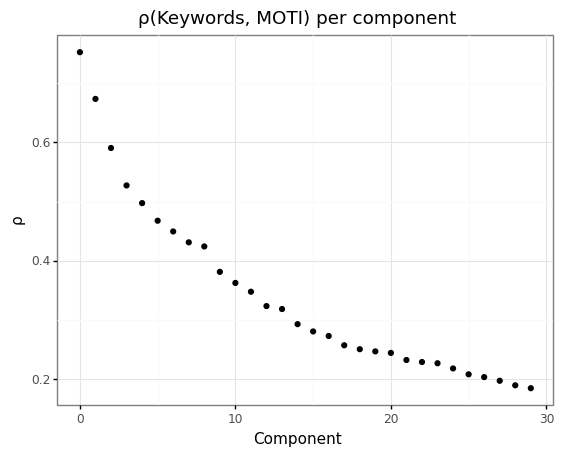

<ggplot: (8749867856901)>

In [70]:
(
    ggplot(
        pd.DataFrame({"component":range(30),"correlation":dims_30}),
        aes(x='component',y='correlation')
    ) 
    + geom_point()
    + ggtitle("ρ(Keywords, MOTI) per component")
    + theme_bw()
    + labs(x='Component',y='ρ')
)

## Define transform for Fasttext and MOTI vectors

In [71]:
class TransformAndFasttext():
    
    def __init__(self, ft_model, sk_model):
        
        self.sk_model = sk_model
        self.ft_model = ft_model
    
    def get_sentence_vector(self, X):
        """
        Take in a string and do the CCA transform after getting
        the fasttext vector back
        """
        
        return self.sk_model.transform(np.expand_dims(
            self.ft_model.get_sentence_vector(X)
            ,0))
    
    def get_content_vector(self, Y):
        """
        Take in a numpy array of moti vectors and do the
        CCA transform. 
        
        Average the matrix down to a 1d vector before returning.
        
        I'm fitting MOTI in the second 'block'
        of CCA and sklearn needs an input X to fit an input Y,
        so we generate a dummy input X that gets thrown away.
        """
    
        dummy_X = np.zeros((Y.shape[0], self.sk_model.x_rotations_.shape[0]))

        _, y_transformed = self.sk_model.transform(dummy_X, Y)

        return np.mean(y_transformed, axis=0, keepdims=True)
        

In [72]:
quick_brown_fox = ft_model.get_sentence_vector('quick brown fox')
transformed_quick_brown_fox = cca_model_30.transform(np.expand_dims(quick_brown_fox,0))

np.array_equal(
    TransformAndFasttext(ft_model=ft_model, sk_model=cca_model_30).get_sentence_vector('quick brown fox'), 
    transformed_quick_brown_fox
)

True

In [80]:
_, transformed_moti_0 = cca_model_30.transform(np.zeros((1,300)),np.expand_dims(moti[0],axis=0))

np.array_equal(
    TransformAndFasttext(ft_model=ft_model, sk_model=cca_model_30).get_content_vector(np.expand_dims(moti[0],axis=0)),
    transformed_moti_0
)

True

## Test transformed Fasttext space with benchmarks

### Load Gensim

In [ ]:
# gensim_model = gensim.models.fasttext.load_facebook_vectors(FILES['wiki.en.bin'])

## write to a gensim-native format to cut down on load times

# gensim_model.save(FILES['gensim_fasttext.bin'])

In [81]:
gensim_model = KeyedVectors.load(FILES['gensim_fasttext.bin'])

In [82]:
gensim_model.similarity('banana','coconut')

0.6622028

In [83]:
np.dot(gensim.matutils.unitvec(gensim_model['banana']),
       gensim.matutils.unitvec(gensim_model['coconut']))

0.6622028

In [84]:
np.dot(np.squeeze(gensim.matutils.unitvec(cca_model_30.transform(np.expand_dims(gensim_model['banana'],0)))),
       np.squeeze(gensim.matutils.unitvec(cca_model_30.transform(np.expand_dims(gensim_model['coconut'],0)))))

0.8849729921425455

In [85]:
def cca_similarity(gensim_model, cca_model, w1, w2):
    """Compute cosine similarity between two words.

    Parameters
    ----------
    w1 : str
        Input word.
    w2 : str
        Input word.

    Returns
    -------
    float
        Cosine similarity between `w1` and `w2`.

    """    

    return np.dot(np.squeeze(gensim.matutils.unitvec(cca_model_30.transform(np.expand_dims(gensim_model[w1],0)))),
               np.squeeze(gensim.matutils.unitvec(cca_model_30.transform(np.expand_dims(gensim_model[w2],0)))))

In [86]:
def evaluate_word_pairs_cca(model, cca_model, pairs, delimiter='\t', restrict_vocab=300000,
                        case_insensitive=True, dummy4unknown=False):
    original_vocab = model.vocab
    
    try:
        ok_vocab = [(w, model.vocab[w]) for w in model.index2word[:restrict_vocab]]
        ok_vocab = {w.upper(): v for w, v in reversed(ok_vocab)} if case_insensitive else dict(ok_vocab)

        similarity_gold = []
        similarity_model = []
        oov = 0
        
        model.vocab = ok_vocab
        
        with gensim.utils.open(pairs, 'rb') as fin:
            for line_no, line in enumerate(fin):
                line = gensim.utils.to_unicode(line)
                if line.startswith('#'):
                    # May be a comment
                    continue
                else:
                    try:
                        if case_insensitive:
                            a, b, sim = [word.upper() for word in line.split(delimiter)]
                        else:
                            a, b, sim = [word for word in line.split(delimiter)]
                        sim = float(sim)
                    except (ValueError, TypeError):
#                         logger.info('Skipping invalid line #%d in %s', line_no, pairs)
                        continue
                    if a not in ok_vocab or b not in ok_vocab:
                        oov += 1
                        if dummy4unknown:
#                             logger.debug('Zero similarity for line #%d with OOV words: %s', line_no, line.strip())
                            similarity_model.append(0.0)
                            similarity_gold.append(sim)
                            continue
                        else:
#                             logger.debug('Skipping line #%d with OOV words: %s', line_no, line.strip())
                            continue
                    similarity_gold.append(sim)  # Similarity from the dataset
                    similarity_model.append(cca_similarity(model, cca_model, a, b))  # Similarity from the model        
                
    finally:
        model.vocab = original_vocab
        
    spearman = stats.spearmanr(similarity_gold, similarity_model)
    pearson = stats.pearsonr(similarity_gold, similarity_model)
    if dummy4unknown:
        oov_ratio = float(oov) / len(similarity_gold) * 100
    else:
        oov_ratio = float(oov) / (len(similarity_gold) + oov) * 100

#     logger.debug('Pearson correlation coefficient against %s: %f with p-value %f', pairs, pearson[0], pearson[1])
#     logger.debug(
#         'Spearman rank-order correlation coefficient against %s: %f with p-value %f',
#         pairs, spearman[0], spearman[1]
#     )
#     logger.debug('Pairs with unknown words: %d', oov)
#     self.log_evaluate_word_pairs(pearson, spearman, oov_ratio, pairs)
    return pearson, spearman, oov_ratio

In [87]:
embedding_tests={}

embedding_tests['cca30_wordsim_pearson'],embedding_tests['cca30_wordsim_spearman'], oot = evaluate_word_pairs_cca(gensim_model, cca_model_30, datapath('wordsim353.tsv'))
print(oot)

embedding_tests['cca30_simlex_pearson'],embedding_tests['cca30_simlex_spearman'], oot  = evaluate_word_pairs_cca(gensim_model, cca_model_30, datapath('simlex999.txt'))
print(oot)

embedding_tests['ft_wordsim_pearson'],embedding_tests['ft_wordsim_spearman'], oot = gensim_model.evaluate_word_pairs(datapath('wordsim353.tsv'))
print(oot)

embedding_tests['ft_simlex_pearson'],embedding_tests['ft_simlex_spearman'], oot = gensim_model.evaluate_word_pairs(datapath('simlex999.txt'))
print(oot)

embedding_tests['cca10_wordsim_pearson'],embedding_tests['cca10_wordsim_spearman'], oot = evaluate_word_pairs_cca(gensim_model, cca_model_10, datapath('wordsim353.tsv'))
print(oot)

embedding_tests['cca10_simlex_pearson'],embedding_tests['cca10_simlex_spearman'], oot = evaluate_word_pairs_cca(gensim_model, cca_model_10, datapath('simlex999.txt'))
print(oot)



0.0
0.10010010010010009
0.0
0.10010010010010009
0.0
0.10010010010010009


In [88]:
for i in embedding_tests.items():
    print(i)

('cca30_wordsim_pearson', (0.5828972977317846, 1.6505506953227976e-33))
('cca30_wordsim_spearman', SpearmanrResult(correlation=0.5856087288496598, pvalue=7.063278901738242e-34))
('cca30_simlex_pearson', (0.28730304834925974, 2.0292236748751222e-20))
('cca30_simlex_spearman', SpearmanrResult(correlation=0.2684684053009126, pvalue=6.161992679922702e-18))
('ft_wordsim_pearson', (0.6987674862566057, 5.237752153117423e-53))
('ft_wordsim_spearman', SpearmanrResult(correlation=0.7388081960366618, pvalue=3.98104844873057e-62))
('ft_simlex_pearson', (0.38691726621595274, 5.474274374454837e-37))
('ft_simlex_spearman', SpearmanrResult(correlation=0.3822944375073409, pvalue=4.4265897336000715e-36))
('cca10_wordsim_pearson', (0.5828972977317846, 1.6505506953227976e-33))
('cca10_wordsim_spearman', SpearmanrResult(correlation=0.5856087288496598, pvalue=7.063278901738242e-34))
('cca10_simlex_pearson', (0.28730304834925974, 2.0292236748751222e-20))
('cca10_simlex_spearman', SpearmanrResult(correlation=

In [89]:
word_pairs_df = (
    pd.DataFrame(embedding_tests)
    .transpose()
    .rename(columns={0:'score',1:'p'})
    .reset_index()
    .pipe(lambda x: pd.melt(x, id_vars='index'))
    .assign(source = lambda x: x['index'].str.split('_',expand=True)[0],
           data = lambda x: x['index'].str.split('_',expand=True)[1],
           test = lambda x: x['index'].str.split('_',expand=True)[2])
    .query('variable == "score"')
)

word_pairs_df

,index,variable,value,source,data,test
0,cca30_wordsim_pearson,score,0.582897,cca30,wordsim,pearson
1,cca30_wordsim_spearman,score,0.585609,cca30,wordsim,spearman
2,cca30_simlex_pearson,score,0.287303,cca30,simlex,pearson
3,cca30_simlex_spearman,score,0.268468,cca30,simlex,spearman
4,ft_wordsim_pearson,score,0.698767,ft,wordsim,pearson
5,ft_wordsim_spearman,score,0.738808,ft,wordsim,spearman
6,ft_simlex_pearson,score,0.386917,ft,simlex,pearson
7,ft_simlex_spearman,score,0.382294,ft,simlex,spearman
8,cca10_wordsim_pearson,score,0.582897,cca10,wordsim,pearson
9,cca10_wordsim_spearman,score,0.585609,cca10,wordsim,spearman


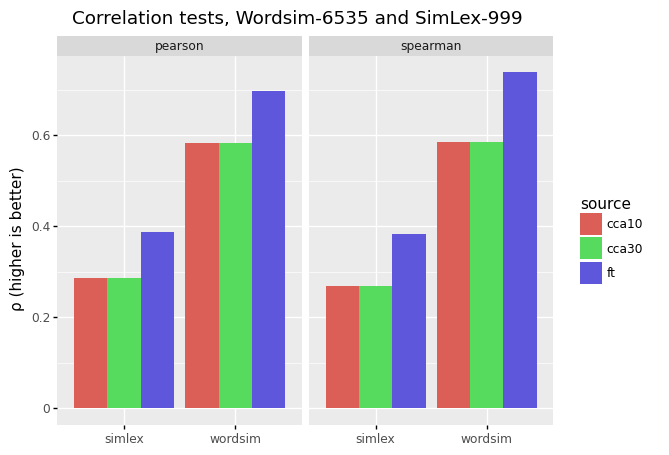

<ggplot: (8749609064225)>

In [90]:
(
    ggplot(word_pairs_df, aes(x='data',y='value',fill='source')) 
    + geom_bar(stat='identity',position='dodge') 
    + facet_wrap('test')
    + ggtitle("Correlation tests, Wordsim-6535 and SimLex-999")
    + labs(x='',y='ρ (higher is better)')
)

## Self-distance tests

In [117]:
distance_dfs = {}

column_transformers = {}

### Pure fasttext

In [118]:
distance_dfs['Fasttext Keywords'] = adv_cont_keywords_df.copy().query('interest_id.isin(@common_audiences_list)')

distance_dfs['Fasttext Keywords'].head(n=3)

,interest_type_id,interest_id,entity_id,descr,summary,domains,content_id,n_url,keywords_json,keyword_list
2,112,11655,40981,Assorted Topics (This Audience Are Interested ...,People in this audience are interested in abbr...,"[usingenglish.com, militaryfactory.com, online...","[d7x, my3s, u5u2, 1o3d4, kre2, 15d3i, unb1, u7...",1426,"{""cell"": 87, ""formula"": 72, ""cell range"": 48, ...","[cell, formula, cell range, array formula, exc..."
4,112,11401,40727,Vermont Cluster,People in this audience are interested in a va...,"[sevendaysvt.com, dailygazette.com, wwnytv.com...","[w68c, ssg4, epcs, fz2d, 10d5y, 1ggqg, cj9e, 1...",4642,"{""new hampshire"": 351, ""covid-19"": 345, ""polic...","[new hampshire, covid-19, police, haverhill, t..."
6,110,6124,26055,Cloud Storage Provider Researchers,Consumers researching and comparing cloud stor...,"[linuxgizmos.com, nakkheeran.in, esmagazine.co...","[emh2, o1ge, 1onmb, fglw, 1o7a8, s70o, 1h0sc, ...",352,"{""nvidia"": 27, ""intel"": 21, ""usb"": 15, ""fierce...","[nvidia, intel, usb, fiercetelecom, cookies, m..."


In [119]:
column_transformers['Fasttext Keywords'] = ColumnComparison(basis_text   =distance_dfs['Fasttext Keywords']['descr'],
                                                            compare_text =distance_dfs['Fasttext Keywords']['keyword_list'].apply(lambda x: ' '.join(x)),
                                                            model        =ft_model)

In [120]:
distance_dfs['Fasttext Keywords'].loc[:,'self_distance']        = column_transformers['Fasttext Keywords'].self_distance
distance_dfs['Fasttext Keywords'].loc[:,'closest_to_name_dist'] = column_transformers['Fasttext Keywords'].best_basis_compare_distance
distance_dfs['Fasttext Keywords'].loc[:,'best_keywords']        = column_transformers['Fasttext Keywords'].best_compare_for_basis
distance_dfs['Fasttext Keywords'].loc[:,'best_interest_name']   = column_transformers['Fasttext Keywords'].basis_of_best_compare
distance_dfs['Fasttext Keywords'].loc[:,'self_search_rank']     = column_transformers['Fasttext Keywords'].basis_self_rank

distance_dfs['Fasttext Keywords'].head(n=3)

,interest_type_id,interest_id,entity_id,descr,summary,domains,content_id,n_url,keywords_json,keyword_list,self_distance,closest_to_name_dist,best_keywords,best_interest_name,self_search_rank
2,112,11655,40981,Assorted Topics (This Audience Are Interested ...,People in this audience are interested in abbr...,"[usingenglish.com, militaryfactory.com, online...","[d7x, my3s, u5u2, 1o3d4, kre2, 15d3i, unb1, u7...",1426,"{""cell"": 87, ""formula"": 72, ""cell range"": 48, ...","[cell, formula, cell range, array formula, exc...",0.263239,0.215517,project excel apqc template charter project ma...,"Assorted Topics (Weather, Movie Studios, Peopl...",4.0
4,112,11401,40727,Vermont Cluster,People in this audience are interested in a va...,"[sevendaysvt.com, dailygazette.com, wwnytv.com...","[w68c, ssg4, epcs, fz2d, 10d5y, 1ggqg, cj9e, 1...",4642,"{""new hampshire"": 351, ""covid-19"": 345, ""polic...","[new hampshire, covid-19, police, haverhill, t...",0.483111,0.398884,paris pageoptions france enquiry pr parisbytra...,Washington County and Local Fair Visitors,794.0
6,110,6124,26055,Cloud Storage Provider Researchers,Consumers researching and comparing cloud stor...,"[linuxgizmos.com, nakkheeran.in, esmagazine.co...","[emh2, o1ge, 1onmb, fglw, 1o7a8, s70o, 1h0sc, ...",352,"{""nvidia"": 27, ""intel"": 21, ""usb"": 15, ""fierce...","[nvidia, intel, usb, fiercetelecom, cookies, m...",0.344463,0.312387,partners cloud-like solutions malware iso chan...,Computer Processor and Data Center Decision Ma...,109.0


### Fasttext + cca transform

In [121]:
distance_dfs['CCA-Fasttext Keywords'] = adv_cont_keywords_df.copy().query('interest_id.isin(@common_audiences_list)')

distance_dfs['CCA-Fasttext Keywords'].head(n=3)

,interest_type_id,interest_id,entity_id,descr,summary,domains,content_id,n_url,keywords_json,keyword_list
2,112,11655,40981,Assorted Topics (This Audience Are Interested ...,People in this audience are interested in abbr...,"[usingenglish.com, militaryfactory.com, online...","[d7x, my3s, u5u2, 1o3d4, kre2, 15d3i, unb1, u7...",1426,"{""cell"": 87, ""formula"": 72, ""cell range"": 48, ...","[cell, formula, cell range, array formula, exc..."
4,112,11401,40727,Vermont Cluster,People in this audience are interested in a va...,"[sevendaysvt.com, dailygazette.com, wwnytv.com...","[w68c, ssg4, epcs, fz2d, 10d5y, 1ggqg, cj9e, 1...",4642,"{""new hampshire"": 351, ""covid-19"": 345, ""polic...","[new hampshire, covid-19, police, haverhill, t..."
6,110,6124,26055,Cloud Storage Provider Researchers,Consumers researching and comparing cloud stor...,"[linuxgizmos.com, nakkheeran.in, esmagazine.co...","[emh2, o1ge, 1onmb, fglw, 1o7a8, s70o, 1h0sc, ...",352,"{""nvidia"": 27, ""intel"": 21, ""usb"": 15, ""fierce...","[nvidia, intel, usb, fiercetelecom, cookies, m..."


In [122]:
cca_transform_model30 = TransformAndFasttext(ft_model=ft_model, sk_model=cca_model_30)

column_transformers['CCA-Fasttext Keywords'] = ColumnComparison(basis_text   =distance_dfs['CCA-Fasttext Keywords']['descr'],
                                                                compare_text =distance_dfs['CCA-Fasttext Keywords']['keyword_list'].apply(lambda x: ' '.join(x)),
                                                                model        =cca_transform_model30)

In [123]:
distance_dfs['CCA-Fasttext Keywords'].loc[:,'self_distance']        = column_transformers['CCA-Fasttext Keywords'].self_distance
distance_dfs['CCA-Fasttext Keywords'].loc[:,'closest_to_name_dist'] = column_transformers['CCA-Fasttext Keywords'].best_basis_compare_distance
distance_dfs['CCA-Fasttext Keywords'].loc[:,'best_keywords']        = column_transformers['CCA-Fasttext Keywords'].best_compare_for_basis
distance_dfs['CCA-Fasttext Keywords'].loc[:,'best_interest_name']   = column_transformers['CCA-Fasttext Keywords'].basis_of_best_compare
distance_dfs['CCA-Fasttext Keywords'].loc[:,'self_search_rank']     = column_transformers['CCA-Fasttext Keywords'].basis_self_rank

distance_dfs['CCA-Fasttext Keywords'].head(n=3)

,interest_type_id,interest_id,entity_id,descr,summary,domains,content_id,n_url,keywords_json,keyword_list,self_distance,closest_to_name_dist,best_keywords,best_interest_name,self_search_rank
2,112,11655,40981,Assorted Topics (This Audience Are Interested ...,People in this audience are interested in abbr...,"[usingenglish.com, militaryfactory.com, online...","[d7x, my3s, u5u2, 1o3d4, kre2, 15d3i, unb1, u7...",1426,"{""cell"": 87, ""formula"": 72, ""cell range"": 48, ...","[cell, formula, cell range, array formula, exc...",0.251577,0.166249,project excel apqc template charter project ma...,"Assorted Topics (Software Integration, Scrabbl...",4.0
4,112,11401,40727,Vermont Cluster,People in this audience are interested in a va...,"[sevendaysvt.com, dailygazette.com, wwnytv.com...","[w68c, ssg4, epcs, fz2d, 10d5y, 1ggqg, cj9e, 1...",4642,"{""new hampshire"": 351, ""covid-19"": 345, ""polic...","[new hampshire, covid-19, police, haverhill, t...",0.868288,0.547738,revision member details server minecraft thema...,Federal Employees,482.0
6,110,6124,26055,Cloud Storage Provider Researchers,Consumers researching and comparing cloud stor...,"[linuxgizmos.com, nakkheeran.in, esmagazine.co...","[emh2, o1ge, 1onmb, fglw, 1o7a8, s70o, 1h0sc, ...",352,"{""nvidia"": 27, ""intel"": 21, ""usb"": 15, ""fierce...","[nvidia, intel, usb, fiercetelecom, cookies, m...",0.408416,0.408416,nvidia intel usb fiercetelecom cookies mirrorl...,Computers,47.0


In [124]:
distance_dfs['CCA-Fasttext Keywords'].head(n=30)[['descr','keyword_list','self_distance','best_keywords','best_interest_name','self_search_rank']]

,descr,keyword_list,self_distance,best_keywords,best_interest_name,self_search_rank
2,Assorted Topics (This Audience Are Interested ...,"[cell, formula, cell range, array formula, exc...",0.251577,project excel apqc template charter project ma...,"Assorted Topics (Software Integration, Scrabbl...",4.0
4,Vermont Cluster,"[new hampshire, covid-19, police, haverhill, t...",0.868288,revision member details server minecraft thema...,Federal Employees,482.0
6,Cloud Storage Provider Researchers,"[nvidia, intel, usb, fiercetelecom, cookies, m...",0.408416,nvidia intel usb fiercetelecom cookies mirrorl...,Computers,47.0
10,Rochester New York Cluster,"[buffalo, new york, capitol, covid-19, vaccine...",0.925664,revision member details server minecraft thema...,Wisconsin County and Local Fair Visitors,696.0
11,Readers of Puerto Rican Content,"[puerto rico, venezuela, para, por, gobierno, ...",0.778752,pollen genus pollen grains iqvia asthma blood ...,Cinco de Mayo Celebrators,104.0
15,"European Museums, Restaurants & Events","[florida, museum, park, cook, beach, resort, f...",0.634240,paris pageoptions france enquiry pr parisbytra...,Sightseeing Travelers,61.0
16,Nintendo Enthusiasts,"[pokémon, game, japan, nintendo, app store, pc...",0.283525,game app store mirrorlessrumors switcharcade r...,Roleplay & Fantasy Games,5.0
18,Premier League Fans,"[arsenal, manchester, manchester city, tottenh...",0.243930,manchester chelsea manchester united solskjaer...,Arsenal Fans,2.0
20,Joint Pain Sufferers,"[pain, arthritis, gout, rheumatoid arthritis, ...",0.483383,patients covid-19 pain symptoms vaccine united...,Arthritis Sufferers,34.0
21,WWE and Pro Wrestling Fans,"[wwe, aew, match, wrestling, ring, nxt, vince ...",0.571739,devices roku nwca flosports app iowa houston t...,Soccer Fans,24.0


### MOTI + CCA

In [125]:
distance_dfs['CCA-MOTI'] = adv_cont_keywords_df.copy().query('interest_id.isin(@common_audiences_list)')

distance_dfs['CCA-MOTI'].head(n=3)

,interest_type_id,interest_id,entity_id,descr,summary,domains,content_id,n_url,keywords_json,keyword_list
2,112,11655,40981,Assorted Topics (This Audience Are Interested ...,People in this audience are interested in abbr...,"[usingenglish.com, militaryfactory.com, online...","[d7x, my3s, u5u2, 1o3d4, kre2, 15d3i, unb1, u7...",1426,"{""cell"": 87, ""formula"": 72, ""cell range"": 48, ...","[cell, formula, cell range, array formula, exc..."
4,112,11401,40727,Vermont Cluster,People in this audience are interested in a va...,"[sevendaysvt.com, dailygazette.com, wwnytv.com...","[w68c, ssg4, epcs, fz2d, 10d5y, 1ggqg, cj9e, 1...",4642,"{""new hampshire"": 351, ""covid-19"": 345, ""polic...","[new hampshire, covid-19, police, haverhill, t..."
6,110,6124,26055,Cloud Storage Provider Researchers,Consumers researching and comparing cloud stor...,"[linuxgizmos.com, nakkheeran.in, esmagazine.co...","[emh2, o1ge, 1onmb, fglw, 1o7a8, s70o, 1h0sc, ...",352,"{""nvidia"": 27, ""intel"": 21, ""usb"": 15, ""fierce...","[nvidia, intel, usb, fiercetelecom, cookies, m..."


In [126]:
null_embedding = 0 * moti[0]

content_id_lookup = collections.defaultdict(lambda: null_embedding,
                                            {x: moti[moti_id(x)] for x in host_keyword_pairs['content_id'].unique()})

In [127]:
cca_transform_model30 = TransformAndFasttext(ft_model=ft_model, sk_model=cca_model_30)

column_transformers['CCA-MOTI'] = MOTIColumnComparison(basis_text   =distance_dfs['CCA-MOTI']['descr'],
                                                       compare_text =distance_dfs['CCA-MOTI']['content_id'].apply(lambda x: np.vstack([content_id_lookup[content_id] for content_id in x])),
                                                       model        =cca_transform_model30)

In [128]:
distance_dfs['CCA-MOTI'].loc[:,'self_distance']        = column_transformers['CCA-MOTI'].self_distance
distance_dfs['CCA-MOTI'].loc[:,'closest_to_name_dist'] = column_transformers['CCA-MOTI'].best_basis_compare_distance
distance_dfs['CCA-MOTI'].loc[:,'best_keywords']        = column_transformers['CCA-MOTI'].best_compare_for_basis
distance_dfs['CCA-MOTI'].loc[:,'best_interest_name']   = column_transformers['CCA-MOTI'].basis_of_best_compare
distance_dfs['CCA-MOTI'].loc[:,'self_search_rank']     = column_transformers['CCA-MOTI'].basis_self_rank

distance_dfs['CCA-MOTI'].head(n=3)

,interest_type_id,interest_id,entity_id,descr,summary,domains,content_id,n_url,keywords_json,keyword_list,self_distance,closest_to_name_dist,best_keywords,best_interest_name,self_search_rank
2,112,11655,40981,Assorted Topics (This Audience Are Interested ...,People in this audience are interested in abbr...,"[usingenglish.com, militaryfactory.com, online...","[d7x, my3s, u5u2, 1o3d4, kre2, 15d3i, unb1, u7...",1426,"{""cell"": 87, ""formula"": 72, ""cell range"": 48, ...","[cell, formula, cell range, array formula, exc...",0.266307,0.223140,"[[0.020915745, -0.11653055, 0.03368042, -0.174...",Assorted Topics (This Audience Are Interested ...,1.0
4,112,11401,40727,Vermont Cluster,People in this audience are interested in a va...,"[sevendaysvt.com, dailygazette.com, wwnytv.com...","[w68c, ssg4, epcs, fz2d, 10d5y, 1ggqg, cj9e, 1...",4642,"{""new hampshire"": 351, ""covid-19"": 345, ""polic...","[new hampshire, covid-19, police, haverhill, t...",0.845572,0.508454,"[[-0.2422151, -0.11979058, 0.05833215, -0.0324...",Lawn & Garden Enthusiasts,266.0
6,110,6124,26055,Cloud Storage Provider Researchers,Consumers researching and comparing cloud stor...,"[linuxgizmos.com, nakkheeran.in, esmagazine.co...","[emh2, o1ge, 1onmb, fglw, 1o7a8, s70o, 1h0sc, ...",352,"{""nvidia"": 27, ""intel"": 21, ""usb"": 15, ""fierce...","[nvidia, intel, usb, fiercetelecom, cookies, m...",0.581519,0.435133,"[[-0.0057829055, -0.16824645, -0.01733164, -0....",Computers,188.0


### Aggregate results

In [129]:
combine_dfs = pd.concat({x:distance_dfs[x][['descr','self_search_rank','self_distance']] for x in distance_dfs},axis=0).reset_index()

combine_dfs.head(n=3)

,level_0,level_1,descr,self_search_rank,self_distance
0,Fasttext Keywords,2,Assorted Topics (This Audience Are Interested ...,4.0,0.263239
1,Fasttext Keywords,4,Vermont Cluster,794.0,0.483111
2,Fasttext Keywords,6,Cloud Storage Provider Researchers,109.0,0.344463


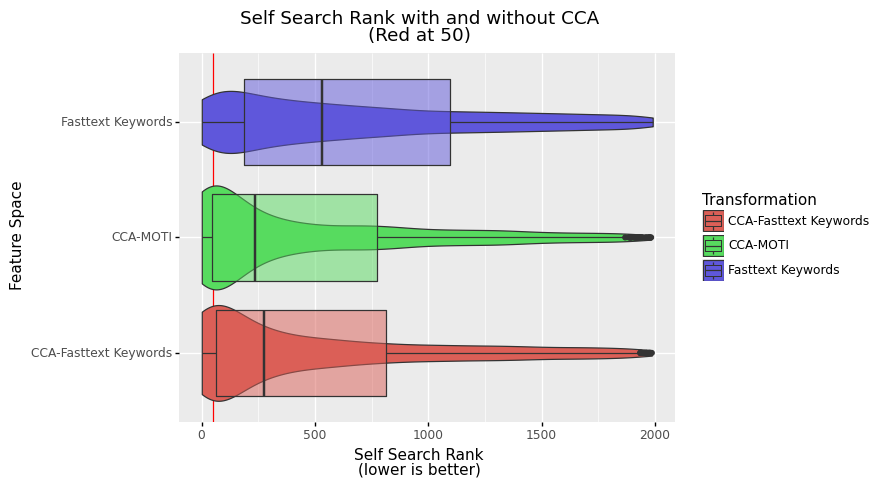

<ggplot: (8749859807985)>

In [130]:
(
    ggplot(
        combine_dfs, 
        aes(x='level_0',y='self_search_rank', fill='level_0'))
    + geom_hline(yintercept=50,color='red')
    + geom_violin()
    + geom_boxplot(alpha=0.5)
    + labs(x='Feature Space', y='Self Search Rank\n(lower is better)',fill='Transformation')
    + coord_flip()
    + ggtitle("Self Search Rank with and without CCA\n(Red at 50)")
)

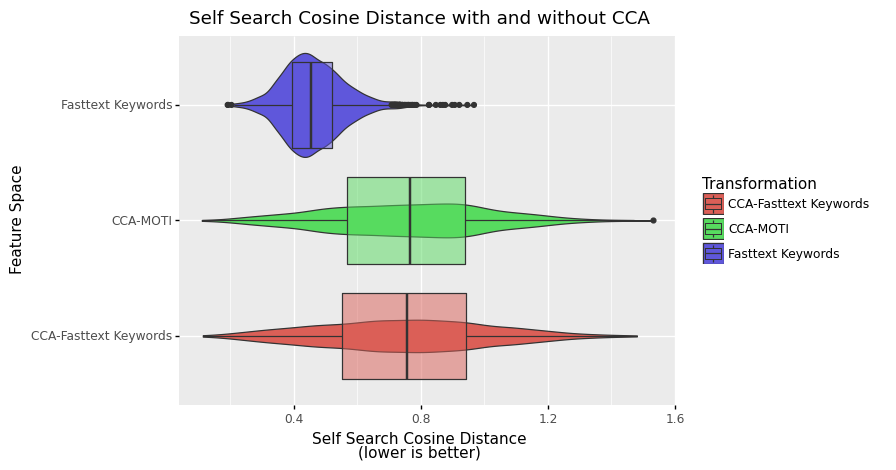

<ggplot: (8749609216181)>

In [131]:
(
    ggplot(
        combine_dfs, 
        aes(x='level_0',y='self_distance', fill='level_0'))
    + geom_violin()
    + geom_boxplot(alpha=0.5)
    + labs(x='Feature Space', y='Self Search Cosine Distance\n(lower is better)',fill='Transformation')
    + coord_flip()
    + ggtitle("Self Search Cosine Distance with and without CCA")
)

## Show fasttext space mutations

### Banana

#### Kick the tires

In [132]:
for i, elem in enumerate(gensim_model.vocab):

    if elem == 'banana':
        print(i)
        break

11548


In [133]:
list(gensim_model.vocab)[11548]

'banana'

In [134]:
np.array_equal(
    gensim_model['banana'],
    gensim_model.vectors[11548,:]
)

True

#### See what's nearby

In [135]:
gensim_model.most_similar('banana')

[('bananas', 0.7954647541046143),
 ('bananana', 0.7523448467254639),
 ('banana$', 0.7323664426803589),
 ('pineapples', 0.6949012875556946),
 ('pineapple', 0.6941430568695068),
 ('bananaa', 0.6828629970550537),
 ('#bananas', 0.6816799640655518),
 ('coconuts', 0.6764993667602539),
 ('coconut', 0.662202775478363),
 ('‘banana', 0.6594933271408081)]

In [136]:
cosine_similarity(
    np.expand_dims(gensim_model.get_vector('banana'),0), 
    np.expand_dims(gensim_model.get_vector('coconut'),0))

array([[0.66220284]], dtype=float32)

In [137]:
## look up nearest words 'by hand'
banana_ft_sim = cosine_similarity(np.expand_dims(gensim_model.vectors[11548,:],0), gensim_model.vectors)

In [138]:
ft_ranks = banana_ft_sim[0].argsort()

In [139]:
for pair in [(list(gensim_model.vocab)[int(x)], banana_ft_sim[0][int(x)]) for x in ft_ranks[-10:][::-1]]:
    print(pair)

('banana', 1.0)
('bananas', 0.7954648)
('bananana', 0.75234485)
('banana$', 0.73236644)
('pineapples', 0.69490147)
('pineapple', 0.6941432)
('bananaa', 0.6828631)
('#bananas', 0.68167996)
('coconuts', 0.6764993)
('coconut', 0.6622028)


#### CCA Transform

In [141]:
altered_vectors = cca_model_30.transform(gensim_model.vectors)

In [142]:
banana_cca_sim = cosine_similarity(np.expand_dims(altered_vectors[11548,:],0),altered_vectors)

In [143]:
cca_ranks = banana_cca_sim[0].argsort()

In [144]:
for pair in [(list(gensim_model.vocab)[int(x)], banana_cca_sim[0][int(x)]) for x in cca_ranks[-11:][::-1]]:
    print(pair)

('banana', 1.0)
('/pineapple', 0.9113843303291816)
('cabbage', 0.9090392222972276)
('pineapple', 0.9026439008584032)
('bananas', 0.8976711035399517)
('spinach', 0.8912134402821594)
('coconut', 0.8849729921425457)
('pineapples', 0.8803143340634272)
('betelnuts', 0.8801714451334174)
('coconutty', 0.8794712754736977)
('beans', 0.8755867947747867)


### Cuteness

#### Kick the tires

In [160]:
for i, elem in enumerate(gensim_model.vocab):

    if elem == 'cuteness':
        print(i)
        break

98326


In [161]:
list(gensim_model.vocab)[98326]

'cuteness'

In [162]:
np.array_equal(
    gensim_model['cuteness'],
    gensim_model.vectors[98326,:]
)

True

#### See what's nearby

In [163]:
gensim_model.most_similar('cuteness')

[('acuteness', 0.7553513050079346),
 ('adorability', 0.6737878322601318),
 ('cheekiness', 0.6707777976989746),
 ('cute', 0.6700284481048584),
 ('geekiness', 0.661678671836853),
 ('tomboyishness', 0.6574928760528564),
 ('wackiness', 0.6542987823486328),
 ('naiveness', 0.653169572353363),
 ('hirsuteness', 0.6520013809204102),
 ('playfulness', 0.6509924530982971)]

In [166]:
cosine_similarity(
    np.expand_dims(gensim_model.get_vector('cuteness'),0), 
    np.expand_dims(gensim_model.get_vector('geekiness'),0))

array([[0.66167873]], dtype=float32)

In [167]:
## look up nearest words 'by hand'
cuteness_ft_sim = cosine_similarity(np.expand_dims(gensim_model.vectors[98326,:],0), gensim_model.vectors)

In [168]:
ft_ranks = cuteness_ft_sim[0].argsort()

In [169]:
for pair in [(list(gensim_model.vocab)[int(x)], cuteness_ft_sim[0][int(x)]) for x in ft_ranks[-10:][::-1]]:
    print(pair)

('cuteness', 1.0000002)
('acuteness', 0.7553514)
('adorability', 0.67378783)
('cheekiness', 0.67077786)
('cute', 0.67002857)
('geekiness', 0.6616788)
('tomboyishness', 0.6574929)
('wackiness', 0.65429884)
('naiveness', 0.6531697)
('hirsuteness', 0.6520015)


#### CCA Transform

In [153]:
# altered_vectors = cca_model_30.transform(gensim_model.vectors)

In [170]:
cuteness_cca_sim = cosine_similarity(np.expand_dims(altered_vectors[98326,:],0),altered_vectors)

In [171]:
cca_ranks = cuteness_cca_sim[0].argsort()

In [172]:
for pair in [(list(gensim_model.vocab)[int(x)], cuteness_cca_sim[0][int(x)]) for x in cca_ranks[-11:][::-1]]:
    print(pair)

('cuteness', 1.0)
('mannerisms', 0.8572540602332028)
('geeky', 0.837268004553372)
('tomboyishness', 0.8291835039444639)
('geekiness', 0.8276438114958986)
('kemonomimi', 0.8273368653695954)
('resemblance', 0.8248549798795165)
('nerd', 0.8170904135995668)
('resemblances', 0.8086607307074036)
('klutzy', 0.8080002780587143)
('obsessed', 0.8046640468957967)
